In [ ]:
import pandas as pd
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install linearmodels
import linearmodels.iv.model as lm
import warnings
warnings.filterwarnings('ignore')
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

### 1. 데이터셋 준비

In [136]:
df = pd.read_csv("/content/drive/MyDrive/4. 석사논문 작성과정 (2021-2)/★학위논문 데이터/★학위논문 데이터 분석 결과/master_data.csv")
df_dropout = pd.read_csv("/content/drive/MyDrive/6. 학위논문 인과추론/SEM_0724.csv")
df = df[['대학몰입1','성별더미','주관적계층의식','코로나학번더미','전공계열','자택더미', '코로나스트레스', '사회적실재감','인지적실재감','교수실재감','교수_학생비대면','교수_학생대면','학생_학생비대면','학생_학생대면','조직커뮤니케이션','LMS지원','비대면서비스지원']]

In [137]:
# 전공계열 더미변수 생성
df_dummy = pd.get_dummies(data = df, columns = ["전공계열"], drop_first = False)

# 데이터셋 병합
df = pd.concat([df_dummy, df_dropout[["Q25A1", "Q25A3"]]], axis=1)
df.rename(columns={"Q25A1":"전출", "Q25A3":"자퇴", "대학몰입1":"대학몰입"}, inplace=True)
df.head()

,대학몰입,성별더미,주관적계층의식,코로나학번더미,자택더미,코로나스트레스,사회적실재감,인지적실재감,교수실재감,교수_학생비대면,...,학생_학생대면,조직커뮤니케이션,LMS지원,비대면서비스지원,전공계열_1,전공계열_2,전공계열_3,전공계열_4,전출,자퇴
0,3.142857,1,5,0,1,5.0,1.000000,3.250000,2.600000,1.25,...,1.000000,2.333333,2.833333,3.666667,1,0,0,0,1,1
1,3.142857,1,6,0,1,4.5,1.388889,3.500000,3.466667,1.00,...,1.000000,2.333333,2.666667,2.000000,0,0,1,0,1,1
2,2.714286,1,7,0,1,2.0,4.888889,5.000000,5.000000,4.00,...,2.000000,2.000000,5.000000,5.000000,1,0,0,0,1,1
3,3.142857,1,8,0,0,4.5,1.666667,4.166667,3.933333,2.25,...,1.666667,1.000000,3.500000,2.000000,0,1,0,0,1,1
4,2.714286,0,5,0,1,4.0,1.833333,3.583333,3.333333,1.50,...,2.000000,2.666667,3.166667,2.333333,0,0,1,0,2,1


In [87]:
display(df["전출"].value_counts())
display(df["자퇴"].value_counts())

1    462
2    238
3    104
4     35
5     15
Name: 전출, dtype: int64

1    640
2    136
3     60
4     10
5      8
Name: 자퇴, dtype: int64

In [138]:
# 데이터 타겟이 될 변수 클래스 재설정

for var in ["전출", "자퇴"]:
  df.loc[(df[var] <= 2), var] = -1
  df.loc[(df[var] == 3), var] = 0
  df.loc[(df[var] >= 4), var] = 1

display(df["전출"].value_counts())
display(df["자퇴"].value_counts())

-1    700
 0    104
 1     50
Name: 전출, dtype: int64

-1    776
 0     60
 1     18
Name: 자퇴, dtype: int64

### 3. 데이터 탐색 및 전처리

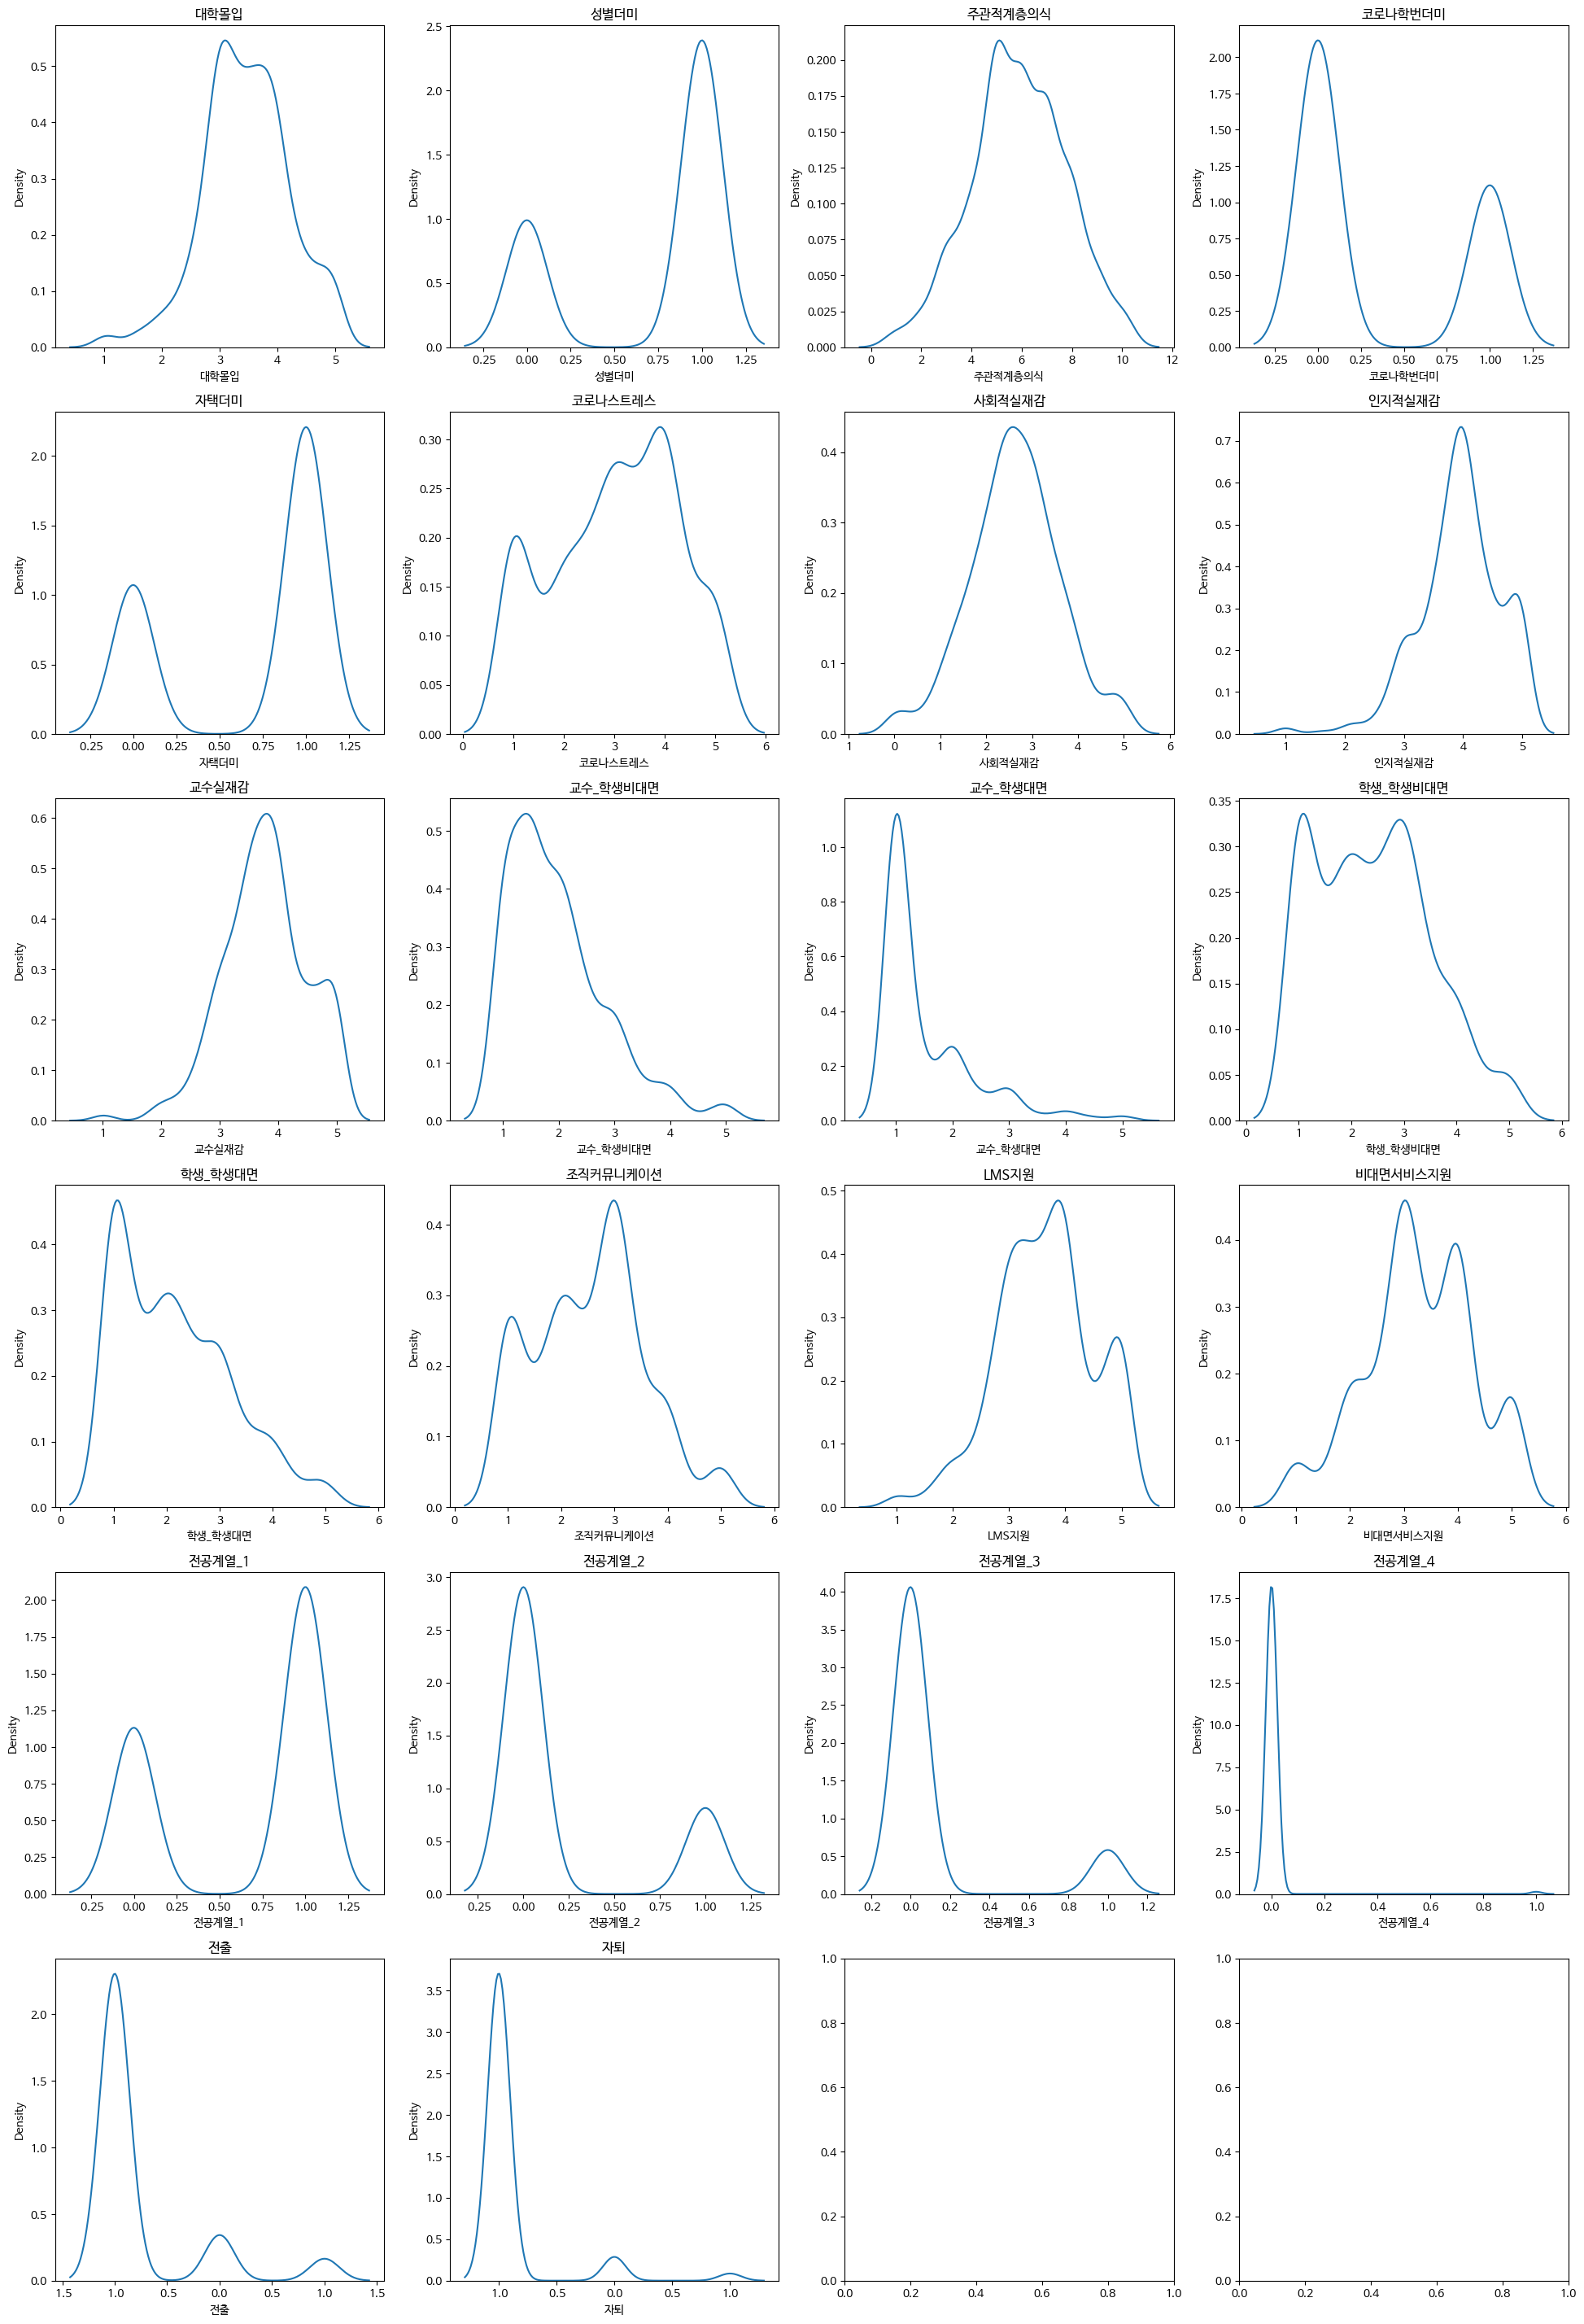

In [90]:
# 변수별 분포 확인
plt.rc('font', family='NanumBarunGothic')

fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(24, 36))
columns = df.columns.to_list()
count = 0

for row in range(6):
  for col in range(4):
    sns.kdeplot(data=df[columns[count]], ax=ax[row][col])
    ax[row][col].set_title(columns[count])
    count += 1
    if count == len(columns):
      break

### 4. 학습

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [139]:
features = df.drop(columns= ["전출", "자퇴", "대학몰입"], axis=1)
target = df["자퇴"]

In [140]:
# 데이터셋 분리
random_seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=random_seed)

In [141]:
# 학습
classifier = RandomForestClassifier(random_state=random_seed)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(f"예측 정확도: {accuracy_score(y_test, y_pred)}")

예측 정확도: 0.9027237354085603


### 5. 교차 검증 (2가지 방법)

In [36]:
from sklearn.model_selection import StratifiedKFold

classifier = RandomForestClassifier(random_state=random_seed)
skfold = StratifiedKFold(n_splits=5)

n_iter = 0
cv_accuracy = []

for train_idx, test_idx in skfold.split(features, target):
  x_train, x_test = features.values[train_idx], features.values[test_idx]
  y_train, y_test = target.values[train_idx], target.values[test_idx]
  classifier.fit(x_train, y_train)
  pred = classifier.predict(x_test)

  n_iter += 1
  accuracy = np.round(accuracy_score(y_test, pred), 4)
  train_size = x_train.shape[0]
  test_size = x_test.shape[0]
  print(f"n_iter: {n_iter}교차 검증 정확도: {accuracy}, 학습데이터 크기: {train_size}, 검증데이터 크기: {test_size} ")
  print(f"검증 세트 인덱스: {test_idx}")
  cv_accuracy.append(accuracy)

print(f"교차 검증별 정확도: {np.round(cv_accuracy, 4)}")
print(f"평균 검증 정확도: {np.round(np.mean(cv_accuracy), 4)}")

n_iter: 1교차 검증 정확도: 0.9181, 학습데이터 크기: 683, 검증데이터 크기: 171 
검증 세트 인덱스: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 188 206 215 279 282 283]
n_iter: 2교차 검증 정확도: 0.9123, 학습데이터 크기: 683, 검증데이터 크기: 171 
검증 세트 인덱스: [165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 207 

In [94]:
from sklearn.model_selection import cross_val_score, cross_validate

classifier = RandomForestClassifier(random_state=random_seed)
scores = cross_val_score(classifier, data.values, target.values, scoring="accuracy", cv=5)
print(f"교차 검증별 정확도: {np.round(scores, 4)}")
print(f"평균 검증 정확도: {np.round(np.mean(scores), 4)}")

교차 검증별 정확도: [0.9181 0.9123 0.9064 0.9064 0.9118]
평균 검증 정확도: 0.911


### 6. 그리드 서치

In [124]:
from sklearn.model_selection import GridSearchCV

grid = {
    'n_estimators' : [100,200],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf' : [3,5,6],
    'min_samples_split' : [2,3,5],
    'max_features': [5, 6, 7]
}

classifier_grid = GridSearchCV(classifier, param_grid = grid, scoring="accuracy", n_jobs=-1, verbose =1)

classifier_grid.fit(x_train, y_train)

print("최고 평균 정확도 : {}".format(classifier_grid.best_score_))
print("최고의 파라미터 :", classifier_grid.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
최고 평균 정확도 : 0.9196218487394958
최고의 파라미터 : {'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


### 7. 변수 중요도 시각화

In [126]:
classifier_best_estimator = classifier_grid.best_estimator_
print(classifier_best_estimator.feature_importances_, '\n')

# 시리즈로 만들어 인덱스 붙이기
ser = pd.Series(classifier_best_estimator.feature_importances_, index=features.columns)

# 내림차순 정렬
top = ser.sort_values(ascending=False)
print(top)

[0.01199787 0.03839136 0.04521561 0.016477   0.05054118 0.06350493
 0.13986708 0.07845848 0.06651679 0.14279348 0.07348324 0.05160843
 0.05516427 0.10210344 0.04302467 0.00570408 0.00600806 0.00914003
 0.        ] 

교수_학생대면     0.142793
인지적실재감      0.139867
LMS지원       0.102103
교수실재감       0.078458
학생_학생비대면    0.073483
교수_학생비대면    0.066517
사회적실재감      0.063505
조직커뮤니케이션    0.055164
학생_학생대면     0.051608
코로나스트레스     0.050541
코로나학번더미     0.045216
비대면서비스지원    0.043025
주관적계층의식     0.038391
자택더미        0.016477
성별더미        0.011998
전공계열_3      0.009140
전공계열_2      0.006008
전공계열_1      0.005704
전공계열_4      0.000000
dtype: float64


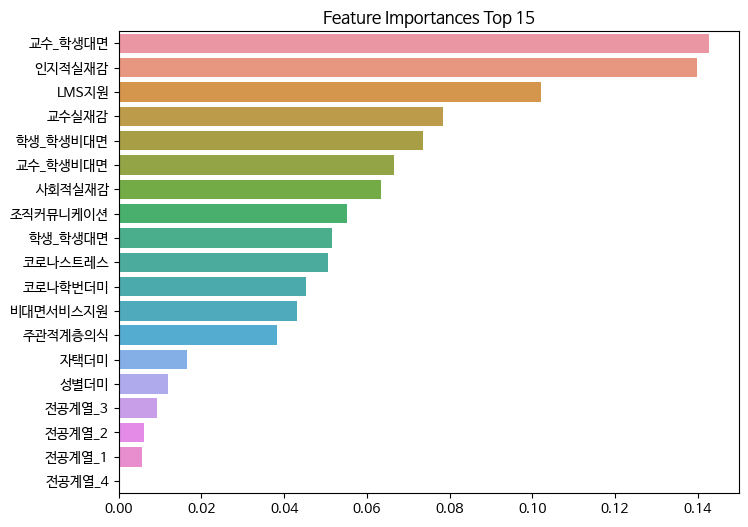

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top, y=top.index)
plt.show()

In [ ]:
!pip install shap
import shap

In [128]:
explainer = shap.TreeExplainer(classifier_best_estimator)
shap_values = explainer.shap_values(x_test)
rf_resultX = pd.DataFrame(shap_values[1], columns = features.columns.to_list())
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(data.columns, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
print(shap_importance)

    col_name  feature_importance_vals
6     사회적실재감                 0.022079
9   교수_학생비대면                 0.017927
2    주관적계층의식                 0.015999
13  조직커뮤니케이션                 0.013891
10   교수_학생대면                 0.009984
8      교수실재감                 0.009418
7     인지적실재감                 0.009110
11  학생_학생비대면                 0.006853
14     LMS지원                 0.005051
12   학생_학생대면                 0.004954
1       성별더미                 0.004923
4       자택더미                 0.004105
5    코로나스트레스                 0.003454
3    코로나학번더미                 0.002168
0       대학몰입                 0.001664
17    전공계열_2                 0.001323
15  비대면서비스지원                 0.000747
16    전공계열_1                 0.000710
18    전공계열_3                 0.000000


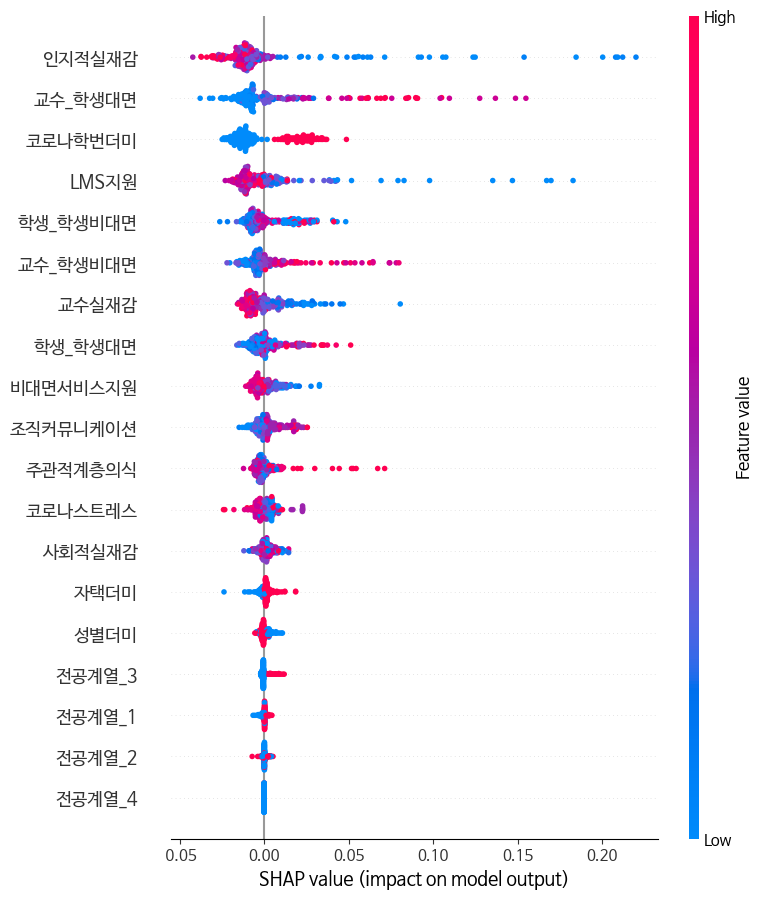

In [131]:
shap.summary_plot(shap_values[1], x_test.values, feature_names = features.columns)

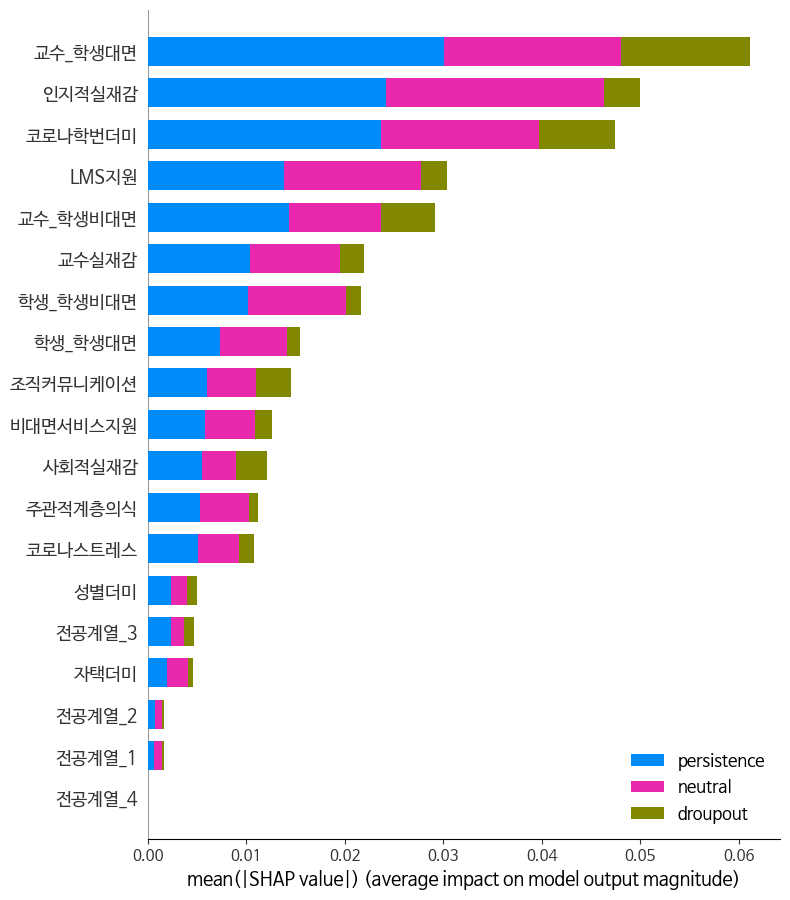

In [135]:
shap.summary_plot(shap_values, features, class_names=["persistence", "neutral", "droupout"])